This notebook provides a backtesting framework to:
- Enable rapid prototyping and testing of trading strategies by composing modular signal and exit logic classes.
- Make it easy for an LLM or user to add new signals, exit logic, or strategies with minimal changes to the base code.
- Provide robust data loading, indicator calculation utilities, and efficient performance reporting.
- Support batch testing across multiple tickers with combined performance analysis.

---
**WHERE AND HOW TO MODIFY THIS NOTEBOOK:**

```
┌─────────────────────────────────────┬─────────────┬───────────────────────────────────────────────────────────────────────┐
│ Section/Class/Function              │ Can Modify? │ How/When?                                                             │
├─────────────────────────────────────┼─────────────┼───────────────────────────────────────────────────────────────────────┤
│ `Signal`/`ExitLogic` subclasses     │ YES         │ Add new subclasses for custom logic. Place them above the main block. │
│ Main execution block                │ YES         │ Instantiate signals/exit logic, run strategies, grid search, batch.   │
│ Batch execution block               │ YES         │ Modify csv_files list to test strategy across multiple tickers.      │
│ `DataLoader`, `IndicatorCalculator` │ YES         │ Change according to input, and also necessary indicators              │
│ `Strategy`, `PerformanceEvaluator`  │ NO          │ Do not change                                                         │
│ Batch testing utilities             │ NO          │ Do not change                                                         │
└─────────────────────────────────────┴─────────────┴───────────────────────────────────────────────────────────────────────┘
```

---
**EXTENSION/USAGE INSTRUCTIONS:**
1. **To add a new indicator:**
   - Add static methods to the IndicatorCalculator class and use for new signals
2. **To add a new signal:**
   - Subclass the `Signal` base class and implement the `generate(self, data)` method.
   - Place your new class above the main execution block.
   - Example:
     ```python
     class MyNewSignal(Signal):
         def generate(self, data):
             # Your logic here
             return pd.Series(...)
     ```
3. **To add new exit logic:**
   - Subclass the `ExitLogic` base class and implement the `should_exit(self, data, position)` method.
   - Place your new class above the main execution block.
   - Example:
     ```python
     class MyExitLogic(ExitLogic):
         def should_exit(self, data, position):
             # Your logic here
             return exited, stop_idx, stop_exit_price
     ```
4. **To define a new strategy:**
   - Only modify the main execution block at the bottom of the notebook.
   - Instantiate your new signal/exit logic classes, add them to the `signals` list and assign to `exit_logic`.
   - Example:
     ```python
     signals = [MyNewSignal(...)]
     exit_logic = MyExitLogic(...)
     strategy = Strategy(signals, exit_logic)
     positions = strategy.run(data)
     results = PerformanceEvaluator.evaluate(positions, data)
     ```
5. **To run batch testing across multiple tickers:**
   - Modify the `csv_files` list in the batch execution block with your ticker CSV files
   - The batch utilities will automatically:
     - Run the strategy on each ticker independently
     - Create a summary comparison table
     - Generate combined equity curves (simple average)
     - Plot individual and combined performance
   - Example:
     ```python
     csv_files = ["AAPL_daily.csv", "MSFT_daily.csv", "GOOGL_daily.csv"]
     # Results automatically stored in batch_results dictionary
     ```

---
**DO NOT MODIFY THE CORE FRAMEWORK:**
- Do NOT change the code for:
  - `Signal` (base class only)
  - `ExitLogic` (base class only)
  - `PerformanceEvaluator`
  - Batch testing utility functions
- Only add new logic via subclasses or by editing the main/batch execution blocks as described above.
- Do NOT introduce look-ahead bias or non-modular code.

---

In [554]:
import pandas as pd
import numpy as np
from typing import List, Dict, Any
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


# Class and Function Definitions (Don't Modify Unless Necessary)

In [555]:
# === DATA LOADER ===
class DataLoader:
    """
    Handles loading and initial preparation of market data.
    Assumes the date column is always 'Date' with format '%Y-%m-%d'.
    """
    def __init__(self, filepath: str):
        self.filepath = filepath

    def load(self) -> pd.DataFrame:
        try:
            # Skip the footer which contains text
            df = pd.read_csv(self.filepath, skipfooter=1, engine='python')
        except FileNotFoundError:
            print(f"Error: The file at {self.filepath} was not found.")
            return pd.DataFrame()
        if 'Date' not in df.columns:
            print("Error: 'Date' column not found in the data.")
            return pd.DataFrame()
        try:
            df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
            df = df.sort_values(by='Date').reset_index(drop=True)
            df.set_index('Date', inplace=True)
            # Ensure numeric types for relevant columns
            for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
            print("Data loaded and prepared successfully. Using 'Date' as index.")
        except Exception as e:
            print(f"Error parsing data: {e}")
            return pd.DataFrame()
        return df

In [556]:
# === INDICATOR CALCULATOR ===
class IndicatorCalculator:
    """
    Utility class for technical indicator calculations.
    """
    @staticmethod
    def add_sma(df: pd.DataFrame, window: int, col: str = 'Close') -> pd.DataFrame:
        df[f'SMA{window}'] = df[col].rolling(window=window).mean()
        return df
    
    @staticmethod
    def add_ema(df: pd.DataFrame, window: int, col: str = 'Close') -> pd.DataFrame:
        df[f'EMA{window}'] = df[col].ewm(span=window, adjust=False).mean()
        return df
    
    @staticmethod
    def add_rsi(df: pd.DataFrame, window: int = 14, col: str = 'Close') -> pd.DataFrame:
        delta = df[col].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))
        return df
    
    @staticmethod
    def add_macd(df: pd.DataFrame, short_window: int = 12, long_window: int = 26, signal_window: int = 9, col: str = 'Close') -> pd.DataFrame:
        ema_short = df[col].ewm(span=short_window, adjust=False).mean()
        ema_long = df[col].ewm(span=long_window, adjust=False).mean()
        df['MACD'] = ema_short - ema_long
        df['MACD_Signal'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
        return df
    
    @staticmethod
    def add_bollinger_bands(df: pd.DataFrame, window: int = 20, num_std: int = 2, col: str = 'Close') -> pd.DataFrame:
        rolling_mean = df[col].rolling(window=window).mean()
        rolling_std = df[col].rolling(window=window).std()
        df['Bollinger_Upper_{window}'] = rolling_mean + (rolling_std * num_std)
        df['Bollinger_Lower_{window}'] = rolling_mean - (rolling_std * num_std)
        return df
    

In [557]:
# === SIGNALS ===
class Signal:
    """
    Base class for all signals. To add a new signal, subclass Signal and implement the generate() method.
    """
    def generate(self, data: pd.DataFrame) -> pd.Series:
        raise NotImplementedError("Each signal must implement the generate method.")


# === EXIT LOGIC ===
class ExitLogic:
    """
    Base class for all exit logics. To add a new exit logic, subclass ExitLogic and implement the should_exit() method.
    """
    def should_exit(self, data: pd.DataFrame, position: dict):
        raise NotImplementedError("Each exit logic must implement the should_exit method.")


In [558]:
# === STRATEGY ===
class Strategy:
    """
    Combines signals and exit logic to generate trades.
    To change strategy behavior, modify how signals are combined or how positions are managed.
    """
    def __init__(self, signals: List[Signal], exit_logic: ExitLogic):
        self.signals = signals
        self.exit_logic = exit_logic

    def run(self, data: pd.DataFrame) -> List[Dict[str, Any]]:
        positions = []
        in_position = False
        entry_price = None
        entry_idx = None

        # Precompute all signals for the entire DataFrame
        precomputed_signals = [sig.generate(data) for sig in self.signals]

        i = 0
        while i < len(data):
            # Check the precomputed signal at index i
            signal = all(sig_series.iloc[i] for sig_series in precomputed_signals) if not precomputed_signals[0].isnull().iloc[i] else False

            if not in_position and signal:
                in_position = True
                entry_price = data['Close'].iloc[i]
                entry_idx = i
                positions.append({'entry_idx': entry_idx, 'entry_price': entry_price})

                # Check for exit on the same bar - not typical but follows the logic
                exited, stop_idx, stop_exit_price = self.exit_logic.should_exit(data, {'entry_price': entry_price, 'entry_idx': entry_idx})
                if exited and stop_idx == i:
                    in_position = False
                    positions[-1]['exit_idx'] = stop_idx
                    positions[-1]['exit_price'] = stop_exit_price
                else: # Find the next exit
                    exited, stop_idx, stop_exit_price = self.exit_logic.should_exit(data, {'entry_price': entry_price, 'entry_idx': entry_idx})
                    if exited:
                        in_position = False
                        positions[-1]['exit_idx'] = stop_idx
                        positions[-1]['exit_price'] = stop_exit_price
                        i = stop_idx # The loop will increment to stop_idx + 1
            elif in_position:
                exited, stop_idx, stop_exit_price = self.exit_logic.should_exit(data, {'entry_price': entry_price, 'entry_idx': entry_idx})
                if exited and i >= stop_idx:
                    in_position = False
                    positions[-1]['exit_idx'] = stop_idx
                    positions[-1]['exit_price'] = stop_exit_price
                    i = stop_idx # The loop will increment to stop_idx + 1

            i += 1

        if in_position and 'exit_idx' not in positions[-1]:
            positions[-1]['exit_idx'] = len(data) - 1
            positions[-1]['exit_price'] = data['Close'].iloc[-1]

        return positions

In [559]:
# === PERFORMANCE EVALUATOR === DO NOT CHANGE UNLESS ABSOLUTELY NECESSARY

class PerformanceEvaluator:
    """
    Evaluates strategy and buy-and-hold performance.
    """
    @staticmethod
    def compute_position_vector(positions: List[Dict[str, Any]], data: pd.DataFrame) -> pd.Series:
        """
        Creates a position vector: 1 when in a position, 0 otherwise.
        """
        pos_vec = np.zeros(len(data))
        for pos in positions:
            if 'exit_idx' in pos and 'entry_idx' in pos:
                entry_idx = pos['entry_idx']
                exit_idx = pos['exit_idx']
                # The slice must include the exit_idx day, hence `exit_idx + 1`.
                # This corrects a flaw in the original implementation.
                pos_vec[entry_idx : exit_idx + 1] = 1
        return pd.Series(pos_vec, index=data.index)

    @staticmethod
    def evaluate(positions: List[Dict[str, Any]], data: pd.DataFrame) -> Dict[str, Any]:
        """
        Calculates performance metrics using an iterative simulation approach.
        """
        # Return zero-values if there are no trades to evaluate.
        if not positions:
            return {
                'total_return': 0.0,
                'max_drawdown': 0.0,
                'num_trades': 0,
                'pct_in_market': 0.0,
                'equity_curve': pd.Series(1.0, index=data.index),
                'drawdown_curve': pd.Series(0.0, index=data.index),
            }

        num_trades = len([p for p in positions if 'exit_idx' in p])

        # --- Iterative Equity Curve Simulation ---
        equity_curve = pd.Series(np.nan, index=data.index)
        current_capital = 1.0
        last_trade_exit_idx = 0

        for pos in positions:
            entry_idx = pos['entry_idx']
            exit_idx = pos.get('exit_idx')

            # 1. Fill the period between the last trade and this one with the stable capital value.
            equity_curve.iloc[last_trade_exit_idx:entry_idx] = current_capital

            entry_price = pos['entry_price']
            if exit_idx is not None:
                exit_price = pos['exit_price']
                # Safety check for valid prices
                if entry_price > 0:
                    # 2. During the trade, equity fluctuates daily based on price changes.
                    price_fluctuation = data['Close'].iloc[entry_idx : exit_idx + 1] / entry_price
                    equity_curve.iloc[entry_idx : exit_idx + 1] = current_capital * price_fluctuation
                    # 3. Update the capital for the *next* trade based on this trade's outcome.
                    current_capital *= (exit_price / entry_price)
                last_trade_exit_idx = exit_idx
            else:
                # This handles an open position at the end of the backtest period.
                # Mark to market at the last available price
                if entry_price > 0:
                    price_fluctuation = data['Close'].iloc[entry_idx:] / entry_price
                    equity_curve.iloc[entry_idx:] = current_capital * price_fluctuation
                    # For total return, treat as if exited at last price
                    current_capital *= (data['Close'].iloc[-1] / entry_price)
                last_trade_exit_idx = len(data) # Mark the end
                break # Exit the loop

        # Fill any remaining period after the last trade with the final capital value.
        equity_curve.iloc[last_trade_exit_idx:] = current_capital
        equity_curve.fillna(1.0, inplace=True) # Ensure the start of the curve is 1.0

        # --- Calculate Final Metrics from the Correct Equity Curve ---
        total_return = equity_curve.iloc[-1] - 1.0
        running_max = equity_curve.cummax()
        drawdown_curve = (equity_curve / running_max) - 1.0
        max_dd = drawdown_curve.min()
        # Calculate auxiliary metrics
        position_vector = PerformanceEvaluator.compute_position_vector(positions, data)
        pct_in_market = position_vector.sum() / len(position_vector) if len(position_vector) > 0 else 0.0

        return {
            'total_return': total_return,
            'max_drawdown': max_dd,
            'num_trades': num_trades,
            'equity_curve': equity_curve,
            'drawdown_curve': drawdown_curve,
            'pct_in_market': pct_in_market
        }

    @staticmethod
    def compare_to_buy_and_hold(data: pd.DataFrame, start_idx: int = 0) -> Dict[str, Any]:
        """
        Calculates the performance of buy-and-hold.
        """
        # Use data from start_idx onward for fair comparison
        comparison_data = data.iloc[start_idx:]
        returns = comparison_data['Close'].pct_change().fillna(0)
        cum_returns = (1 + returns).cumprod()
        total_return = cum_returns.iloc[-1] - 1.0
        running_max = cum_returns.cummax()
        drawdown = (cum_returns / running_max) - 1
        max_dd = drawdown.min()

        # Create full-length series for plotting (padded with 1.0 before start)
        full_cum_returns = pd.Series(1.0, index=data.index)
        full_drawdown = pd.Series(0.0, index=data.index)
        full_cum_returns.iloc[start_idx:] = cum_returns
        full_drawdown.iloc[start_idx:] = drawdown

        return {
            'buy_and_hold_return': total_return,
            'buy_and_hold_max_drawdown': max_dd,
            'buy_and_hold_equity_curve': full_cum_returns,
            'buy_and_hold_drawdown_curve': full_drawdown
        }

    @staticmethod
    def report(results: Dict[str, Any], buy_hold: Dict[str, Any]):
        """
        Prints a formatted report of strategy and buy-and-hold performance.
        """
        print("\n=== Strategy Report ===")
        print(f"Total Return: {results['total_return']:.2%}")
        print(f"Max Drawdown: {results['max_drawdown']:.2%}")
        print(f"Number of Trades: {results['num_trades']}")
        print(f"Pct in Market: {results.get('pct_in_market', 0.0):.2%}")
        print("\n=== Buy and Hold ===")
        print(f"Total Return: {buy_hold['buy_and_hold_return']:.2%}")
        print(f"Max Drawdown: {buy_hold['buy_and_hold_max_drawdown']:.2%}")

In [560]:
# === BATCH TESTING UTILITIES ===

def create_batch_summary_table(batch_results: Dict[str, Any]) -> pd.DataFrame:
    """
    Creates a summary table comparing performance across multiple tickers.

    Args:
        batch_results: Dictionary with ticker names as keys and result dictionaries as values

    Returns:
        DataFrame with one row per ticker showing key metrics
    """
    summary_data = []

    for ticker, ticker_data in batch_results.items():
        results = ticker_data['results']
        buy_hold = ticker_data['buy_hold']

        summary_data.append({
            'Ticker': ticker,
            'Strategy Return': results['total_return'],
            'Strategy Max DD': results['max_drawdown'],
            'Num Trades': results['num_trades'],
            '% in Market': results['pct_in_market'],
            'B&H Return': buy_hold['buy_and_hold_return'],
            'B&H Max DD': buy_hold['buy_and_hold_max_drawdown'],
            'Outperformance': results['total_return'] - buy_hold['buy_and_hold_return']
        })

    df = pd.DataFrame(summary_data)

    # Add average row
    avg_row = {
        'Ticker': 'AVERAGE',
        'Strategy Return': df['Strategy Return'].mean(),
        'Strategy Max DD': df['Strategy Max DD'].mean(),
        'Num Trades': df['Num Trades'].mean(),
        '% in Market': df['% in Market'].mean(),
        'B&H Return': df['B&H Return'].mean(),
        'B&H Max DD': df['B&H Max DD'].mean(),
        'Outperformance': df['Outperformance'].mean()
    }
    df = pd.concat([df, pd.DataFrame([avg_row])], ignore_index=True)

    return df


def calculate_combined_equity(batch_results: Dict[str, Any]) -> pd.Series:
    """
    Calculates combined equity curve as simple average of all ticker equity curves.
    Handles different date ranges by using union of all dates.

    Args:
        batch_results: Dictionary with ticker names as keys and result dictionaries as values

    Returns:
        Series representing the averaged equity curve across all tickers
    """
    # Collect all equity curves
    equity_curves = {}
    for ticker, ticker_data in batch_results.items():
        equity_curves[ticker] = ticker_data['results']['equity_curve']

    # Create union date index
    all_dates = pd.DatetimeIndex([])
    for equity in equity_curves.values():
        all_dates = all_dates.union(equity.index)
    all_dates = all_dates.sort_values()

    # Reindex all curves to union dates and forward fill
    aligned_curves = []
    for ticker, equity in equity_curves.items():
        # Reindex and forward fill (assumes held position continues)
        aligned = equity.reindex(all_dates, method='ffill')
        # Backward fill initial NaNs with 1.0 (not started yet)
        aligned = aligned.fillna(1.0)
        aligned_curves.append(aligned)

    # Simple average across all tickers
    combined = pd.concat(aligned_curves, axis=1).mean(axis=1)

    return combined


def plot_batch_results(batch_results: Dict[str, Any], show_individual: bool = True):
    """
    Plots batch testing results including individual and combined views.

    Args:
        batch_results: Dictionary with ticker names as keys and result dictionaries as values
        show_individual: If True, shows individual plots for each ticker
    """
    # Plot 1: All equity curves overlaid
    plt.figure(figsize=(14, 7))

    for ticker, ticker_data in batch_results.items():
        equity = ticker_data['results']['equity_curve']
        plt.plot(equity.index, equity.values, label=f'{ticker} Strategy', alpha=0.7)

    # Add combined equity curve
    combined_equity = calculate_combined_equity(batch_results)
    plt.plot(combined_equity.index, combined_equity.values,
             label='Combined (Avg)', color='black', linewidth=2.5, linestyle='--')

    plt.title('All Tickers - Strategy Equity Curves', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Equity Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot 2: Combined strategy vs average buy & hold
    plt.figure(figsize=(14, 7))

    plt.plot(combined_equity.index, combined_equity.values,
             label='Combined Strategy', color='blue', linewidth=2)

    # Calculate average buy & hold
    bh_curves = []
    for ticker, ticker_data in batch_results.items():
        bh_equity = ticker_data['buy_hold']['buy_and_hold_equity_curve']
        aligned = bh_equity.reindex(combined_equity.index, method='ffill').fillna(1.0)
        bh_curves.append(aligned)
    avg_bh = pd.concat(bh_curves, axis=1).mean(axis=1)

    plt.plot(avg_bh.index, avg_bh.values,
             label='Average Buy & Hold', color='orange', linewidth=2, linestyle='--')

    plt.title('Combined Strategy vs Average Buy & Hold', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Equity Value')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot 3: Individual ticker plots
    if show_individual:
        for ticker, ticker_data in batch_results.items():
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

            # Equity curve
            equity = ticker_data['results']['equity_curve']
            bh_equity = ticker_data['buy_hold']['buy_and_hold_equity_curve']

            ax1.plot(equity.index, equity.values, label='Strategy', color='blue')
            ax1.plot(bh_equity.index, bh_equity.values, label='Buy & Hold',
                    color='orange', linestyle='--')
            ax1.set_title(f'{ticker} - Equity Curve Comparison', fontsize=14)
            ax1.set_ylabel('Equity Value')
            ax1.legend()
            ax1.grid(alpha=0.3)

            # Drawdown
            strategy_dd = ticker_data['results']['drawdown_curve']
            bh_dd = ticker_data['buy_hold']['buy_and_hold_drawdown_curve']

            ax2.plot(strategy_dd.index, strategy_dd, label='Strategy DD', color='red')
            ax2.plot(bh_dd.index, bh_dd, label='B&H DD', color='grey', linestyle='--')
            ax2.fill_between(strategy_dd.index, strategy_dd, 0, color='red', alpha=0.15)
            ax2.fill_between(bh_dd.index, bh_dd, 0, color='grey', alpha=0.15)
            ax2.axhline(0, color='black', linestyle='-', linewidth=1.0)
            ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
            ax2.set_title(f'{ticker} - Drawdown Comparison', fontsize=14)
            ax2.set_ylabel('Drawdown from Peak')
            ax2.set_xlabel('Date')
            ax2.legend()
            ax2.grid(True, linestyle=':', linewidth=0.5)

            plt.tight_layout()
            plt.show()

# Modify Below for Strategy Development

In [ ]:
# === EXAMPLE SIGNAL AND EXIT LOGIC CLASSES ===
# Add your Signal and ExitLogic subclasses here


# === SIGNAL LOGIC CLASSES ===
class CombinedDualMASignal(Signal):
    """
    Combines immediate long entry with dual MA crossover re-entries.
    Buys on first day, then uses golden cross for re-entries after exits.
    """
    def __init__(self, fast_period: int = 20, slow_period: int = 50):
        self.fast_period = fast_period
        self.slow_period = slow_period

    def generate(self, data: pd.DataFrame) -> pd.Series:
        # Start with immediate buy signal on first day
        signal = pd.Series(False, index=data.index)
        signal.iloc[0] = True  # Buy on first day

        # Add dual MA crossover signals for re-entries
        fast_ma = data['Close'].rolling(window=self.fast_period).mean()
        slow_ma = data['Close'].rolling(window=self.slow_period).mean()

        # Golden cross: fast MA crosses above slow MA
        above = (fast_ma > slow_ma).fillna(False)
        above_prev = above.shift(1).fillna(False)
        ma_crossover = above & (~above_prev)

        # Combine: immediate entry OR golden cross
        signal = signal | ma_crossover

        return signal

class MACDCrossoverSignal(Signal):
    """
    Generates entry signals based on MACD line crossing above the signal line.
    Optionally triggers an immediate buy on the first day.
    """
    def __init__(self, fast: int = 12, slow: int = 26, signal: int = 9, buy_first_day: bool = True):
        self.fast = fast
        self.slow = slow
        self.signal = signal
        self.buy_first_day = buy_first_day

    def generate(self, data: pd.DataFrame) -> pd.Series:
        signal_series = pd.Series(False, index=data.index)

        # Optional: Buy on the very first day
        if self.buy_first_day:
            signal_series.iloc[0] = True

        # === Compute MACD ===
        ema_fast = data["Close"].ewm(span=self.fast, adjust=False).mean()
        ema_slow = data["Close"].ewm(span=self.slow, adjust=False).mean()

        macd = ema_fast - ema_slow
        macd_signal = macd.ewm(span=self.signal, adjust=False).mean()

        # === Bullish crossover ===
        # MACD crosses above signal line
        bullish = (macd > macd_signal) & (macd.shift(1) <= macd_signal.shift(1))
        bullish = bullish.fillna(False)

        # Combine with first-day entry
        signal_series = signal_series | bullish

        return signal_series

class RSIThresholdSignal(Signal):
    """
    Generates entry signals when RSI crosses above a specified threshold.
    """
    def __init__(self, threshold: float = 30.0, window: int = 14):
        self.threshold = threshold
        self.window = window

    def generate(self, data: pd.DataFrame) -> pd.Series:
        rsi_series = IndicatorCalculator.add_rsi(data.copy(), window=self.window)['RSI']
        signal_series = pd.Series(False, index=data.index)

        # RSI crosses above threshold
        above = (rsi_series > self.threshold).fillna(False)
        above_prev = above.shift(1).fillna(False)
        rsi_crossover = above & (~above_prev)

        signal_series = rsi_crossover

        return signal_series
    
class BollingerBandBreakoutSignal(Signal):
    """
    Generates entry signals when price breaks above the upper Bollinger Band.
    """
    def __init__(self, window: int = 20, num_std: int = 2):
        self.window = window
        self.num_std = num_std

    def generate(self, data: pd.DataFrame) -> pd.Series:
        df = IndicatorCalculator.add_bollinger_bands(data.copy(), window=self.window, num_std=self.num_std)
        signal_series = pd.Series(False, index=data.index)

        upper_band = df[f'Bollinger_Upper_{self.window}']

        # Price breaks above upper Bollinger Band
        breakout = (data['Close'] > upper_band).fillna(False)
        breakout_prev = breakout.shift(1).fillna(False)
        band_breakout = breakout & (~breakout_prev)

        signal_series = band_breakout

        return signal_series
   
# === EXIT LOGIC CLASSES ===
class DualMovingAverageExit(ExitLogic):
    """
    Exits when fast MA crosses below slow MA (death cross).
    Classic dual moving average strategy exit condition.
    """
    def __init__(self, fast_period: int = 10, slow_period: int = 25, stop_loss: float = 0.15):
        self.fast_period = fast_period
        self.slow_period = slow_period
        self.stop_loss = stop_loss

    def should_exit(self, data: pd.DataFrame, position: dict):
        entry_idx = position['entry_idx']
        entry_price = position['entry_price']

        # Pre-calculate moving averages for efficiency
        fast_ma = data['Close'].rolling(window=self.fast_period).mean()
        slow_ma = data['Close'].rolling(window=self.slow_period).mean()

        # Check from entry point onward
        for i in range(entry_idx + 1, len(data)):  # Start from next day
            current_price = data['Close'].iloc[i]
            return_pct = (current_price - entry_price) / entry_price

            # Exit on stop loss (protect capital)
            if return_pct <= -self.stop_loss:
                return True, i, current_price

            # Exit when fast MA crosses below slow MA (death cross)
            if i >= self.slow_period and not pd.isna(fast_ma.iloc[i]) and not pd.isna(slow_ma.iloc[i]):
                if fast_ma.iloc[i] < slow_ma.iloc[i] and fast_ma.iloc[i-1] >= slow_ma.iloc[i-1]:
                    return True, i, current_price

        return False, None, None
    


    
class MACDExitLogic(ExitLogic):
    """
    Exit when the MACD line crosses below the signal line (bearish crossover).
    """
    def __init__(self, fast: int = 12, slow: int = 26, signal: int = 9):
        self.fast = fast
        self.slow = slow
        self.signal = signal

    def should_exit(self, data: pd.DataFrame, position: dict):
        entry_idx = position['entry_idx']

        # Compute MACD and signal line over full data
        ema_fast = data["Close"].ewm(span=self.fast, adjust=False).mean()
        ema_slow = data["Close"].ewm(span=self.slow, adjust=False).mean()

        macd = ema_fast - ema_slow
        macd_signal = macd.ewm(span=self.signal, adjust=False).mean()

        # Loop from the bar AFTER the entry
        for i in range(entry_idx + 1, len(data)):
            # Bearish crossover: MACD goes below signal
            if (macd.iloc[i] < macd_signal.iloc[i]) and (macd.iloc[i-1] >= macd_signal.iloc[i-1]):
                exit_price = data["Close"].iloc[i]
                return True, i, exit_price

        # No exit signal
        return False, None, None
    
class RSIThresholdExit(ExitLogic):
    """
    Exit when RSI crosses above a specified threshold.
    """
    def __init__(self, threshold: float = 70.0, window: int = 14):
        self.threshold = threshold
        self.window = window

    def should_exit(self, data: pd.DataFrame, position: dict):
        entry_idx = position['entry_idx']

        rsi_series = IndicatorCalculator.add_rsi(data.copy(), window=self.window)['RSI']

        # Loop from the bar AFTER the entry
        for i in range(entry_idx + 1, len(data)):
            # RSI crosses above threshold
            if rsi_series.iloc[i] > self.threshold and rsi_series.iloc[i-1] <= self.threshold:
                exit_price = data["Close"].iloc[i]
                return True, i, exit_price

        # No exit signal
        return False, None, None
    
class BollingerBandExit(ExitLogic):
    """
    Exit when price breaks below the lower Bollinger Band.
    """
    def __init__(self, window: int = 20, num_std: int = 2):
        self.window = window
        self.num_std = num_std

    def should_exit(self, data: pd.DataFrame, position: dict):
        entry_idx = position['entry_idx']

        df = IndicatorCalculator.add_bollinger_bands(data.copy(), window=self.window, num_std=self.num_std)
        lower_band = df[f'Bollinger_Lower_{self.window}']

        # Loop from the bar AFTER the entry
        for i in range(entry_idx + 1, len(data)):
            # Price breaks below lower Bollinger Band
            if data['Close'].iloc[i] < lower_band.iloc[i]:
                exit_price = data["Close"].iloc[i]
                return True, i, exit_price

        # No exit signal
        return False, None, None
    


In [562]:
# === MAIN EXECUTION BLOCK (Modify Accordingly) ===
# Strategy: Start long on day 1, use dual MA for exits and re-entries
signals = [
    # CombinedDualMASignal(fast_period=10, slow_period=50)  # Combined immediate entry + re-entry signals
    MACDCrossoverSignal(fast=2, slow=5, signal=9, buy_first_day=True)  # MACD crossover with first day buy
    # RSIThresholdSignal(threshold=30.0, window=14)  # RSI oversold entry
    # BollingerBandBreakoutSignal(window=20, num_std=2)  # Bollinger Band breakout entry

]


exit_logic = DualMovingAverageExit(fast_period=10, slow_period=50, stop_loss=0.075)

# Execution and Results Reporting

Batch Testing: Run the same strategy across multiple tickers and analyze combined results

RUNNING BATCH BACKTEST

--- Processing HUT ---
Data loaded and prepared successfully. Using 'Date' as index.
Strategy Return: 3008.26%
Buy & Hold Return: 1143.45%
Trades: 52

--- Processing IOVA ---
Data loaded and prepared successfully. Using 'Date' as index.
Strategy Return: -93.19%
Buy & Hold Return: -91.34%
Trades: 56

--- Processing JOBY ---
Data loaded and prepared successfully. Using 'Date' as index.
Strategy Return: -37.25%
Buy & Hold Return: 55.24%
Trades: 45

--- Processing KULR ---
Data loaded and prepared successfully. Using 'Date' as index.
Strategy Return: -55.87%
Buy & Hold Return: -65.92%
Trades: 64

--- Processing LTRX ---
Data loaded and prepared successfully. Using 'Date' as index.
Strategy Return: 60.61%
Buy & Hold Return: 35.48%
Trades: 36

--- Processing MSTR ---
Data loaded and prepared successfully. Using 'Date' as index.
Strategy Return: 1541.52%
Buy & Hold Return: 1948.58%
Trades: 43

--- Processing POET ---
Data loaded and prepared successfully. Using 'Date' 

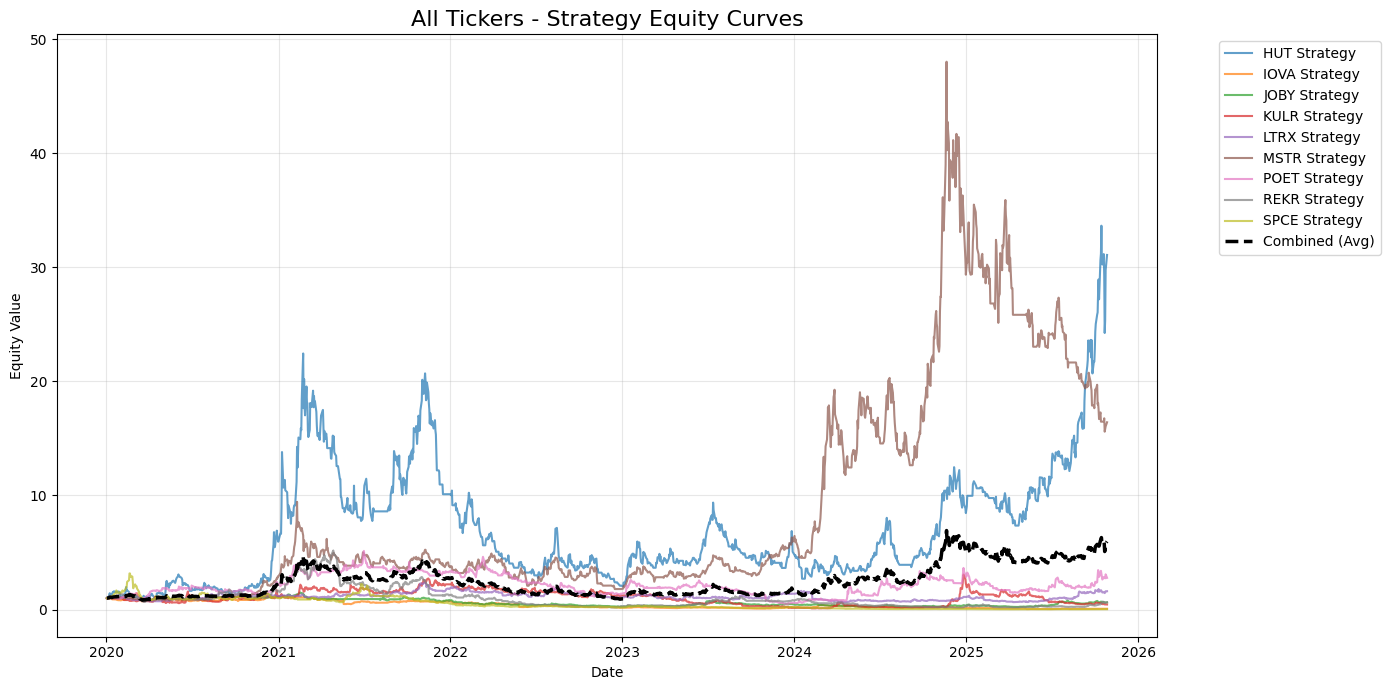

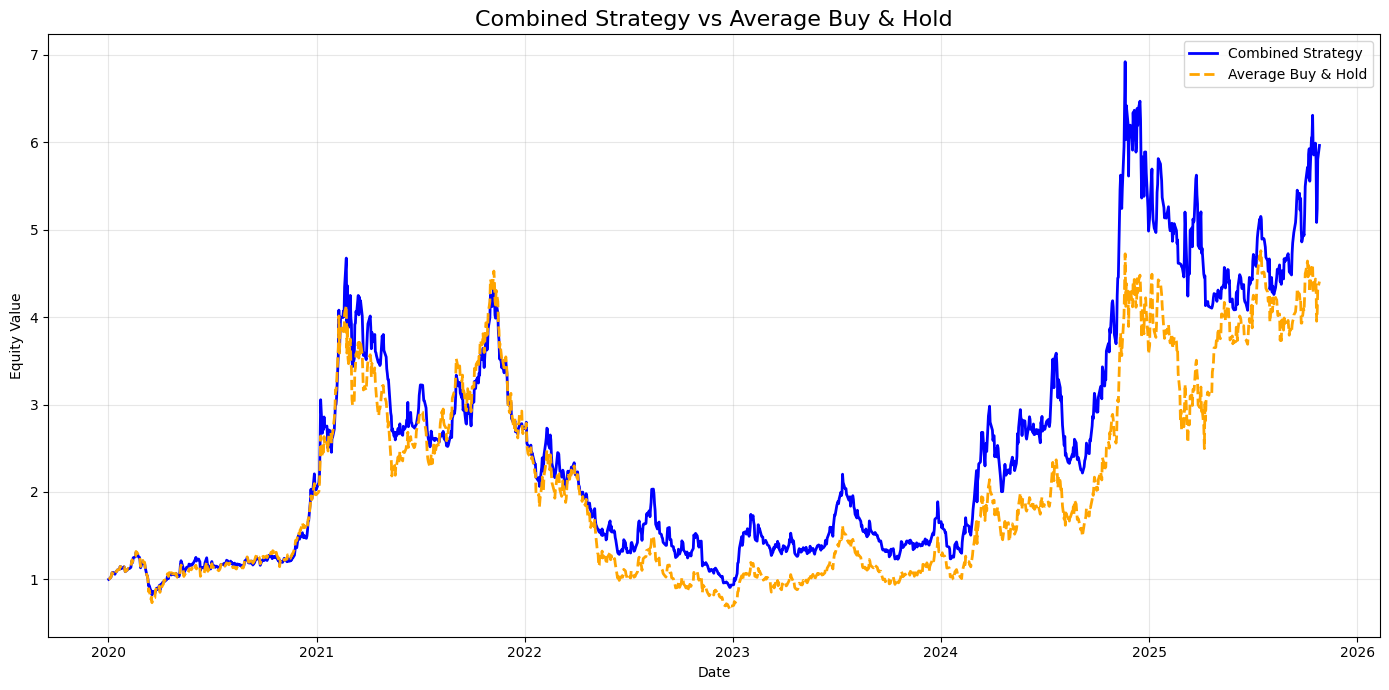

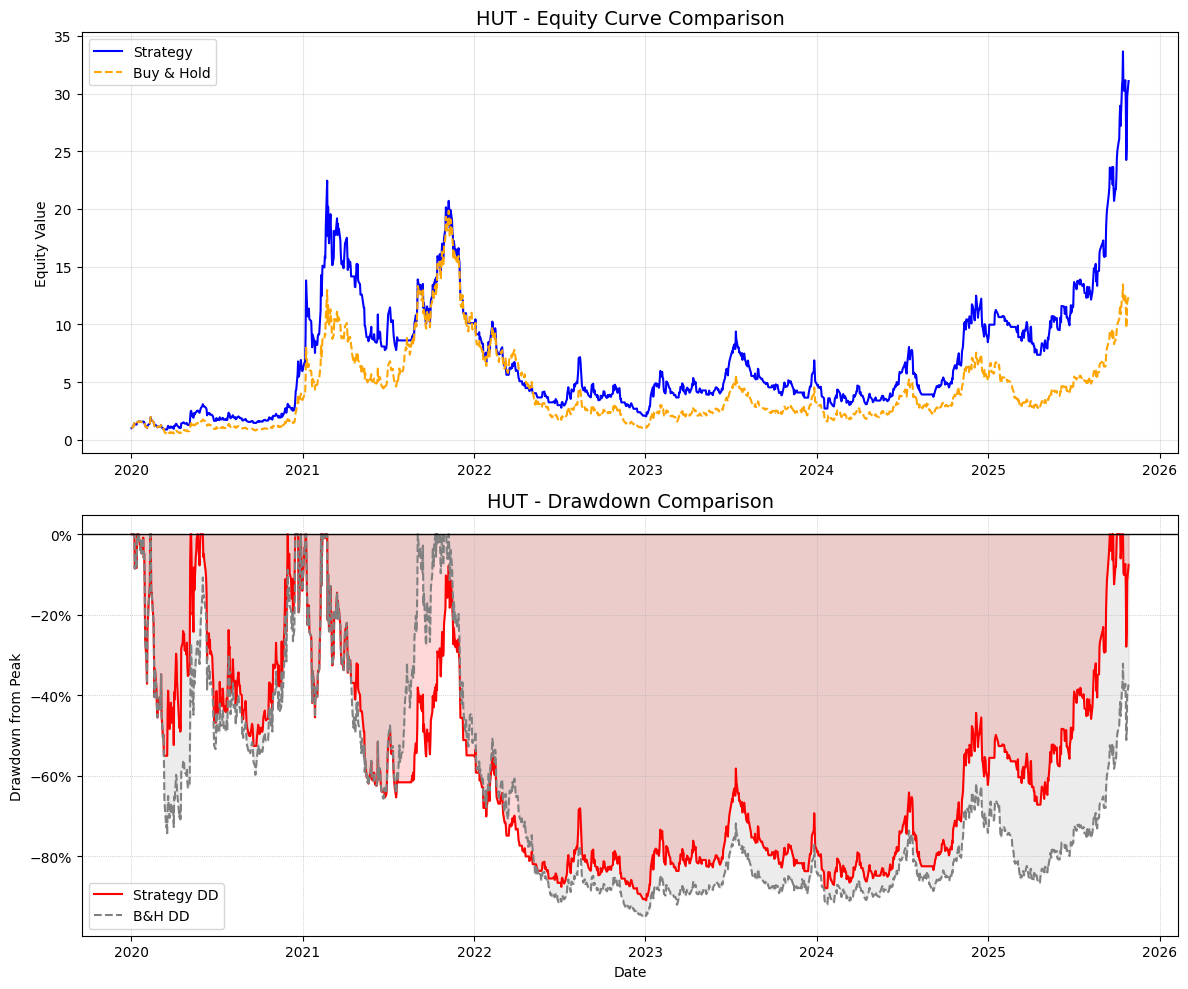

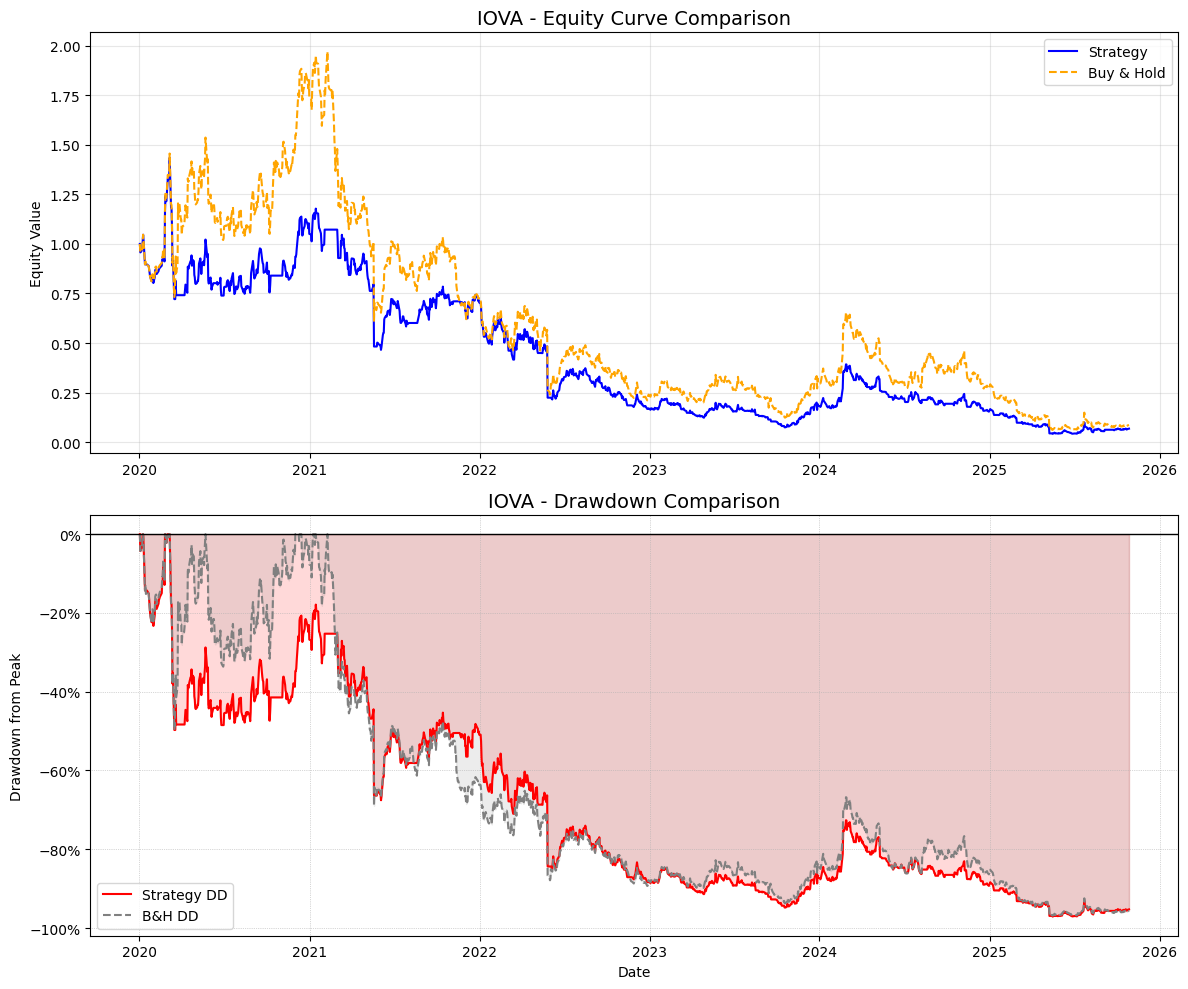

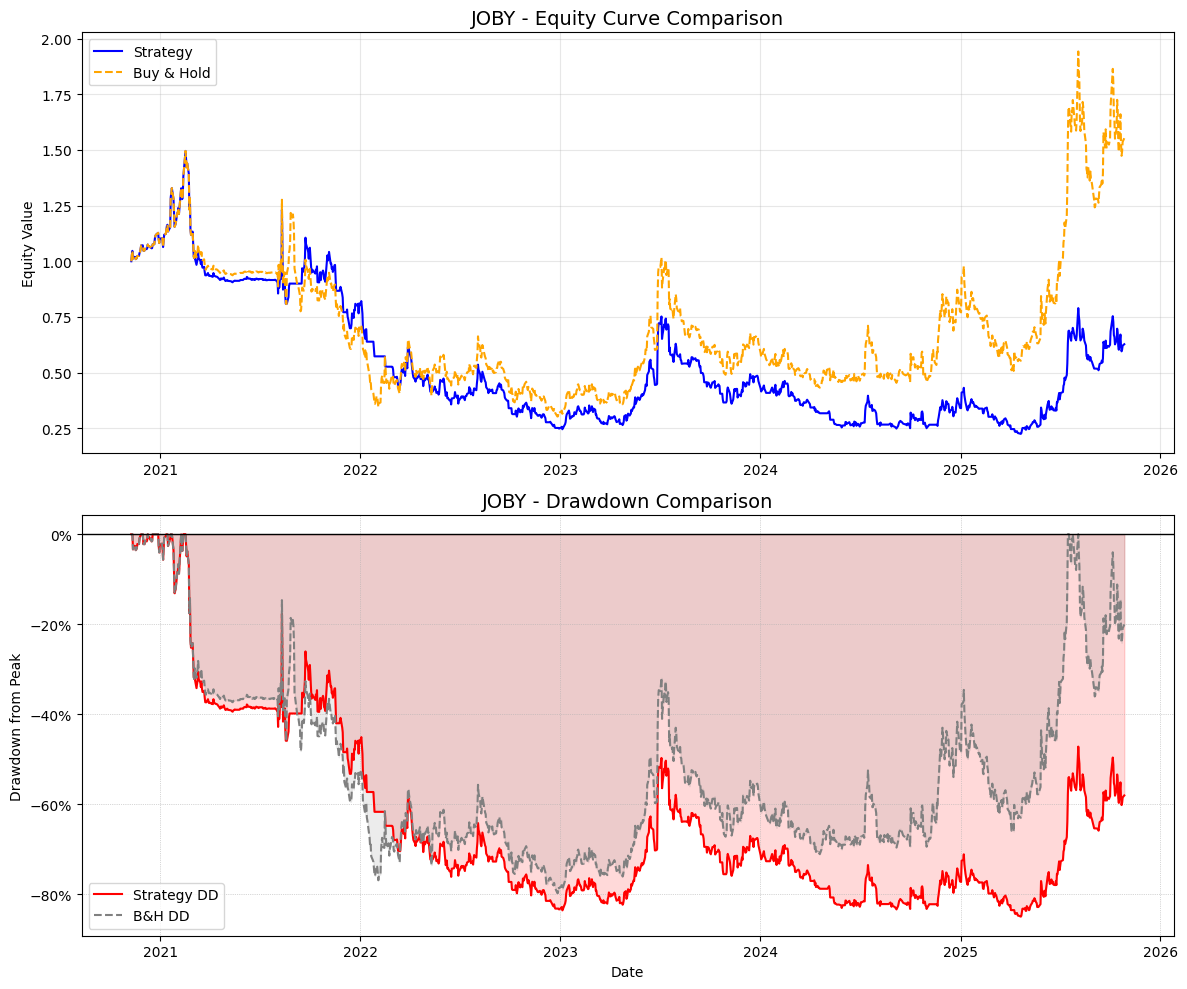

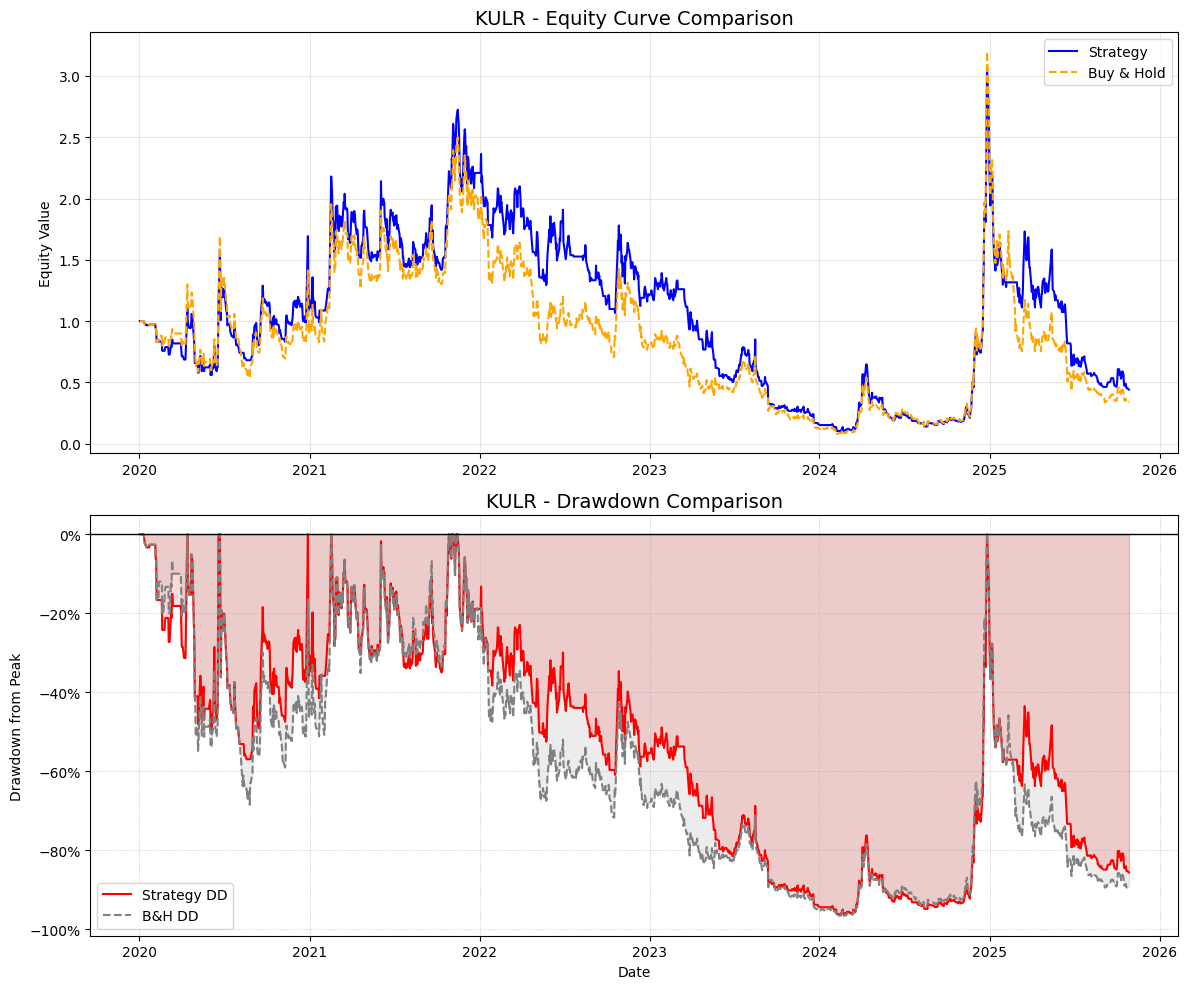

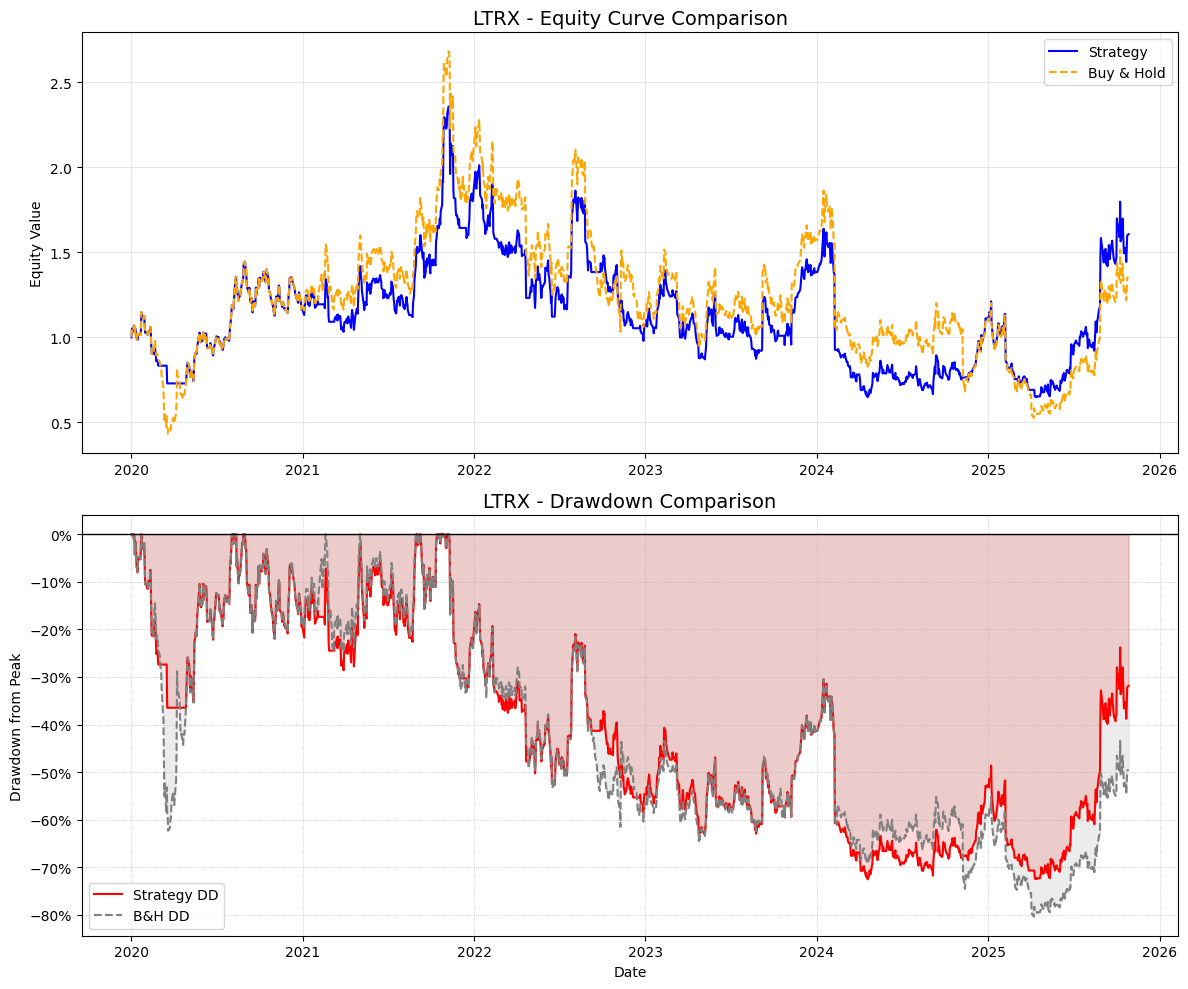

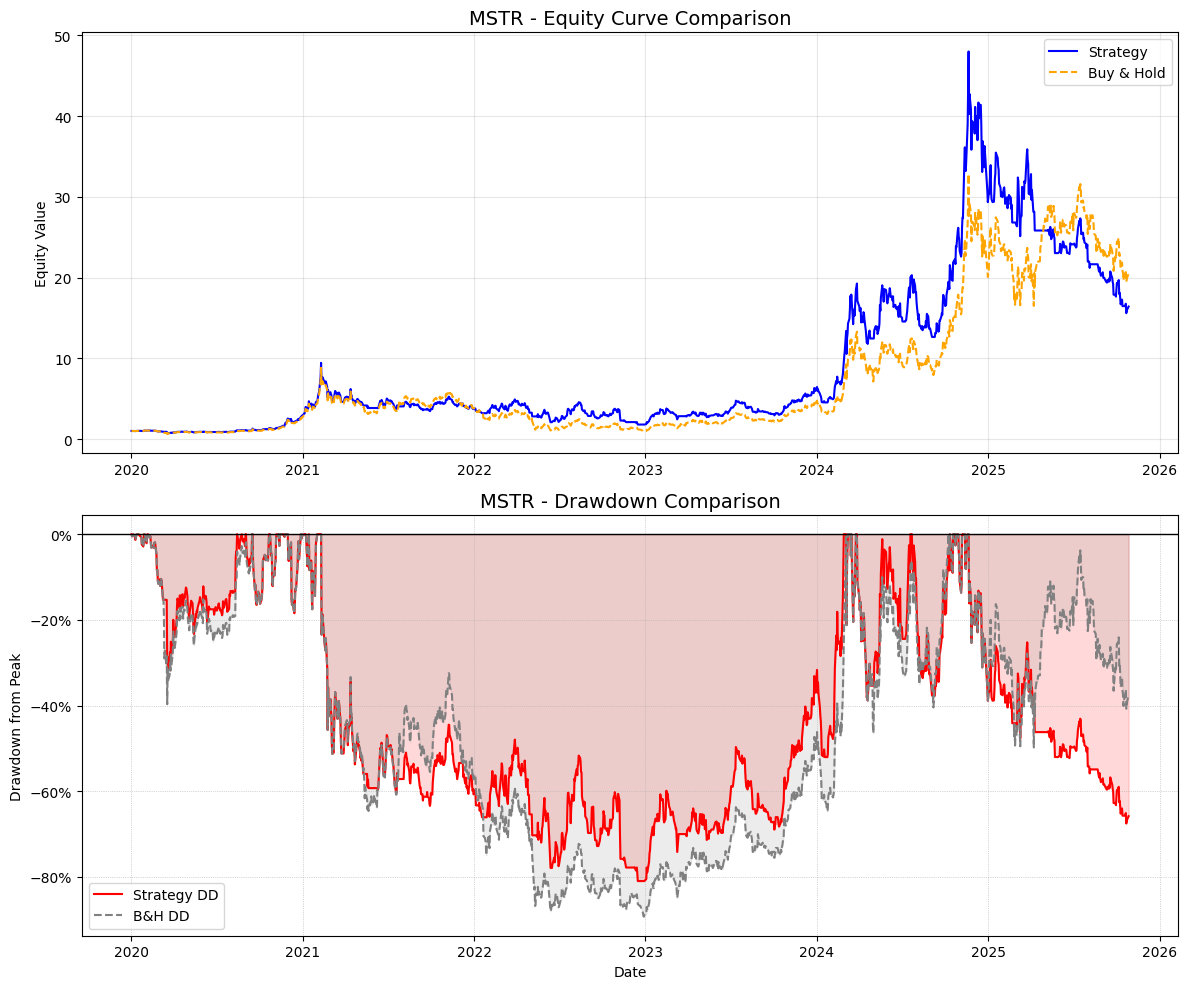

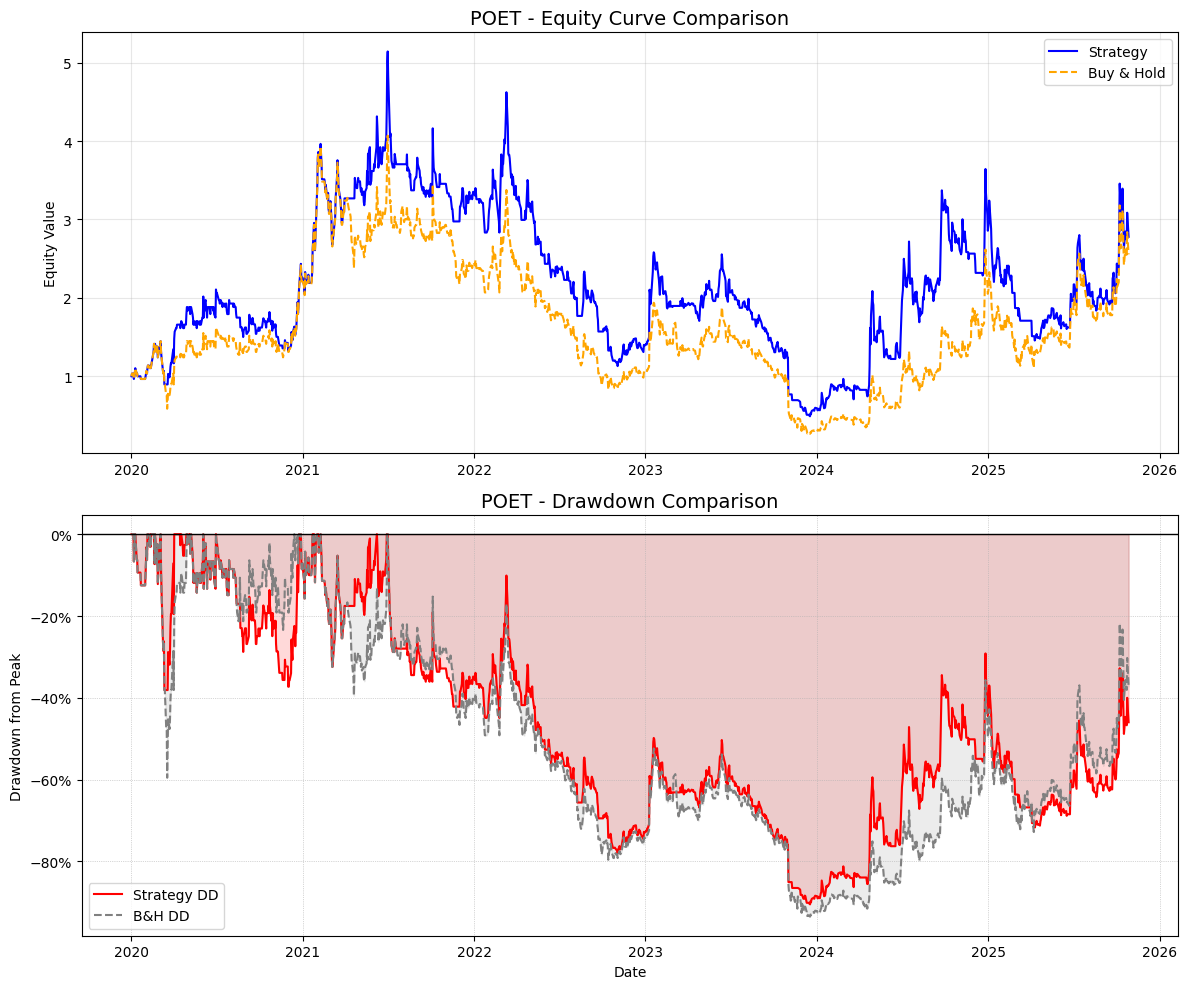

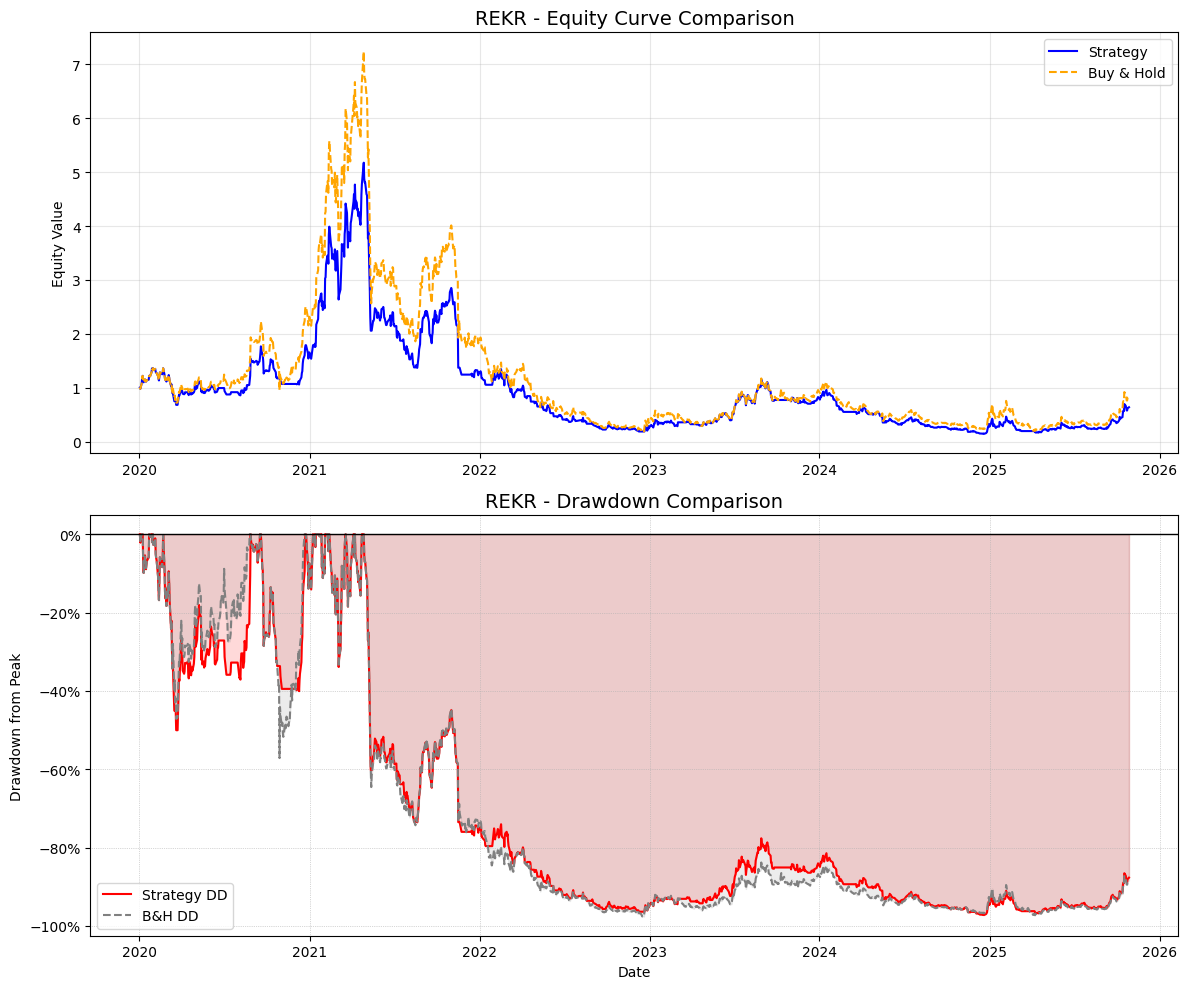

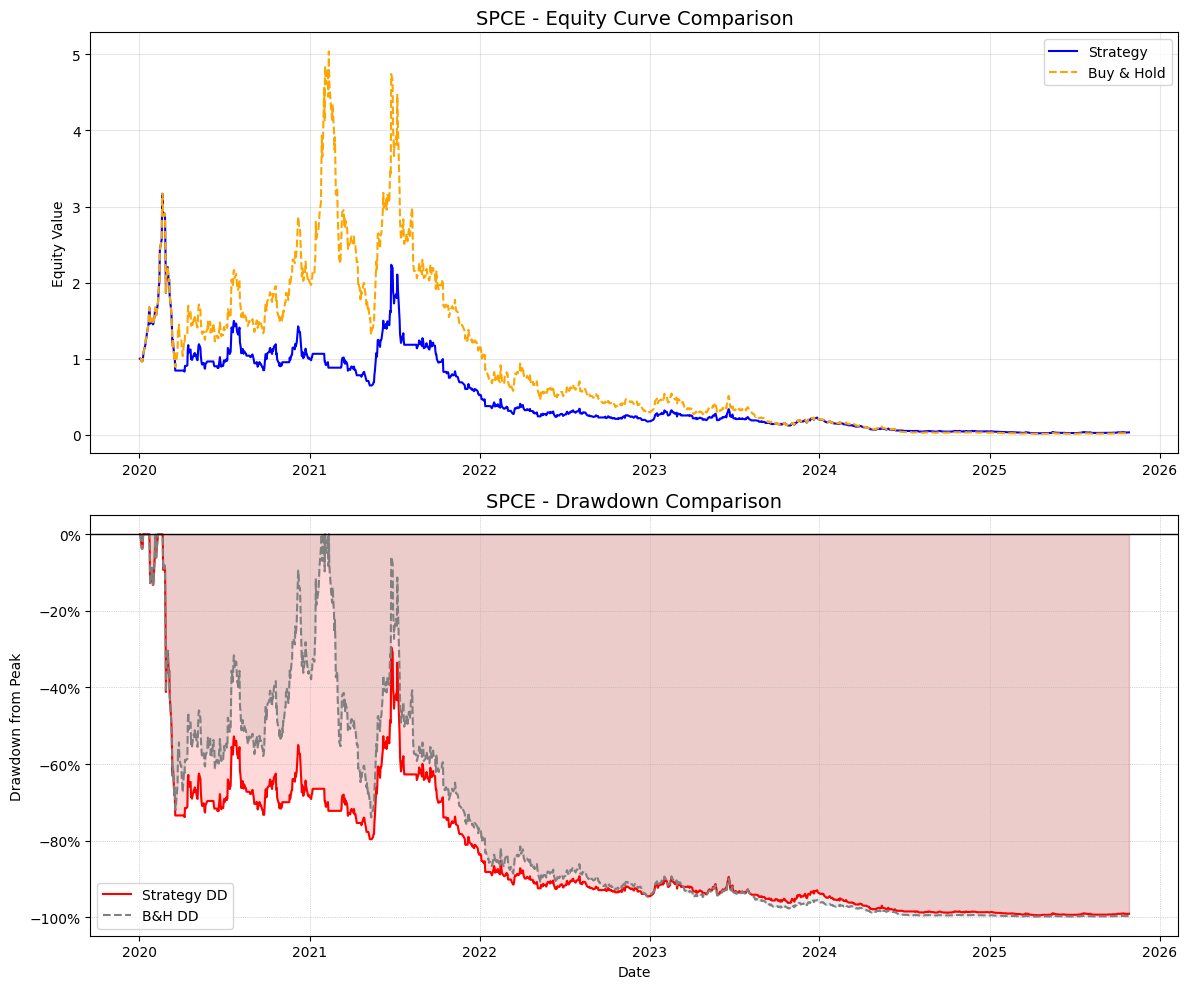


BATCH BACKTEST COMPLETE


In [563]:
# === BATCH EXECUTION EXAMPLE ===

# Dictionary of CSV files to test with ticker name and file path as key and value respectively
csv_files = {
    'HUT': "./dataFolder/HUT_1d.csv",
    'IOVA': "./dataFolder/IOVA_1d.csv",
    'JOBY': "./dataFolder/JOBY_1d.csv",
    'KULR': "./dataFolder/KULR_1d.csv",
    'LTRX': "./dataFolder/LTRX_1d.csv",
    'MSTR': "./dataFolder/MSTR_1d.csv",
    'POET': "./dataFolder/POET_1d.csv",
    'REKR': "./dataFolder/REKR_1d.csv",
    'RKLB': "./datFolder/RKLB_1d.csv",
    'SPCE': "./dataFolder/SPCE_1d.csv",

}

# Storage for batch results
batch_results = {}

print("=" * 60)
print("RUNNING BATCH BACKTEST")
print("=" * 60)

# Run strategy on each ticker
for ticker, csv_path in csv_files.items():
    # Extract ticker name from filename
    ticker = ticker

    print(f"\n--- Processing {ticker} ---")

    # Load data
    data = DataLoader(csv_path).load()
    if data.empty:
        print(f"Skipping {ticker} - no data loaded")
        continue

    # Run strategy (using signals and exit_logic defined above)
    strategy = Strategy(signals, exit_logic)
    positions = strategy.run(data)
    results = PerformanceEvaluator.evaluate(positions, data)

    # Calculate buy & hold comparison
    first_trade_idx = positions[0]['entry_idx'] if positions else 0
    buy_hold = PerformanceEvaluator.compare_to_buy_and_hold(data, first_trade_idx)


    # Store results
    batch_results[ticker] = {
        'data': data,
        'positions': positions,
        'results': results,
        'buy_hold': buy_hold
    }

    # Quick summary
    print(f"Strategy Return: {results['total_return']:.2%}")
    print(f"Buy & Hold Return: {buy_hold['buy_and_hold_return']:.2%}")
    print(f"Trades: {results['num_trades']}")

# Display summary table
if batch_results:
    print("\n" + "=" * 60)
    print("BATCH SUMMARY TABLE")
    print("=" * 60)

    summary_table = create_batch_summary_table(batch_results)

    # Format for better display
    pd.options.display.float_format = '{:.2%}'.format
    print(summary_table.to_string(index=False))
    pd.options.display.float_format = None  # Reset formatting

    # Plot all results
    print("\nGenerating plots...")
    plot_batch_results(batch_results, show_individual=True)

    print("\n" + "=" * 60)
    print("BATCH BACKTEST COMPLETE")
    print("=" * 60)
else:
    print("\nNo valid results to display.")

BASELINE (SMA Crossover):

 Ticker  AVERAGE

 Strategy Return  316.21% 

 Strategy Max DD -78.67% 

 Num Trades  2011.11% 

 % in Market 43.01% 

 B&H Return  340.76%

 B&H Max DD  -92.11%
 
 Outperformance -24.55%
                                            
